--- PHASE 1: Searching for Assets ---
Selected Portfolio: [NVDA, NEE, BTC-USD]


C:\Users\Anklesh\AppData\Local\Temp\ipykernel_17420\2788498014.py:43: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2023-01-01", end="2025-01-01")['Close']
[*********************100%***********************]  3 of 3 completed
C:\Users\Anklesh\AppData\Local\Temp\ipykernel_17420\2788498014.py:46: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


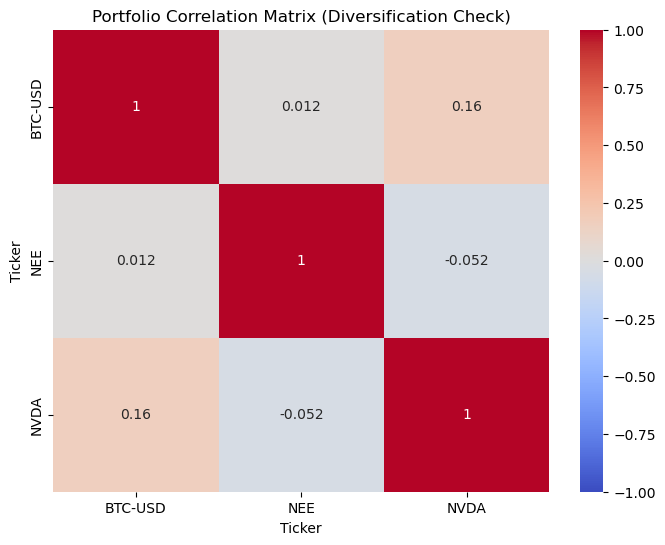

--- Portfolio Report ---
Final Value of $10k: $39,985.27
Sharpe Ratio: 1.95 (Above 1.0 is generally good)


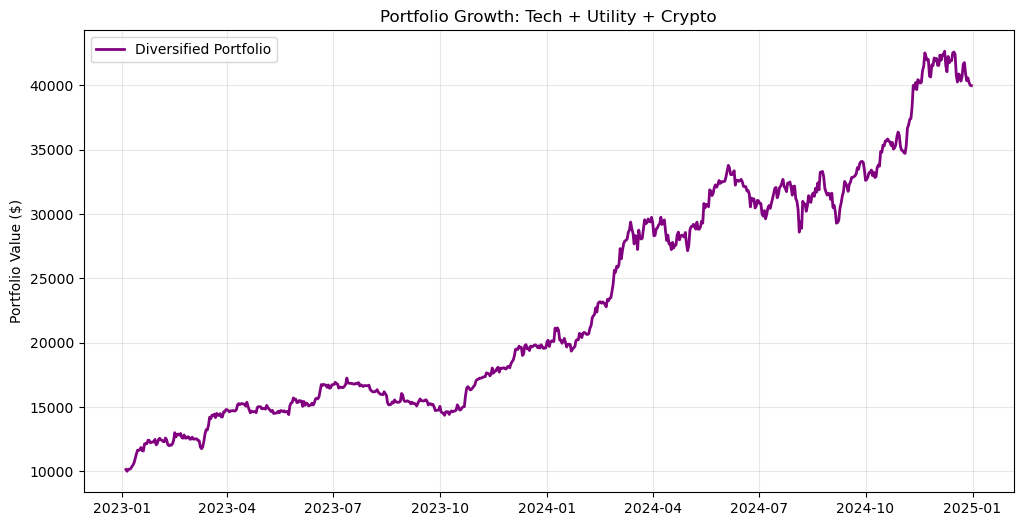

In [1]:
import financedatabase as fd
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# PHASE 1: DISCOVERY (The "Phonebook")
# Goal: Find 1 Tech stock, 1 Defensive stock, and 1 Crypto ticker
# ==========================================
print("--- PHASE 1: Searching for Assets ---")

# 1. Initialize databases
equities = fd.Equities()
cryptos = fd.Cryptos()

# 2. Search for a "Semiconductor" stock (Growth)
# We look for large companies in the US Semiconductor industry
tech_search = equities.search(country='United States', industry='Semiconductors', market_cap='Large Cap')
tech_stock = 'NVDA' # We pick Nvidia from the list (Simulated selection)

# 3. Search for a "Utilities" stock (Defense/Stability)
# Utilities usually hold value when tech crashes
util_search = equities.search(country='United States', sector='Utilities', market_cap='Large Cap')
defensive_stock = 'NEE' # NextEra Energy (A common defensive pick)

# 4. Search for a Crypto (Speculative/Diversifier)
crypto_search = cryptos.search(summary='Bitcoin')
crypto_asset = 'BTC-USD'

print(f"Selected Portfolio: [{tech_stock}, {defensive_stock}, {crypto_asset}]")

# ==========================================
# PHASE 2: DATA & CONSTRUCTION
# Goal: Build the portfolio and assign weights
# ==========================================
tickers = [tech_stock, defensive_stock, crypto_asset]
weights = np.array([0.5, 0.3, 0.2]) # 50% Tech, 30% Defensive, 20% Crypto

# Download Data (last 2 years)
# Note: auto_adjust=True is default, so 'Close' is already adjusted
data = yf.download(tickers, start="2023-01-01", end="2025-01-01")['Close']

# Calculate Daily Returns
returns = data.pct_change().dropna()

# ==========================================
# PHASE 3: EXPANSION - RISK ANALYSIS
# Goal: Correlation Matrix (Crucial for PMs)
# ==========================================
# PM Logic: If everything is green (correlation > 0.8), you aren't diversified.
# You want some red/blue (low/negative correlation).
plt.figure(figsize=(8, 6))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Portfolio Correlation Matrix (Diversification Check)")
plt.show()

# ==========================================
# PHASE 4: EXPANSION - PERFORMANCE METRICS
# Goal: Sharpe Ratio & Cumulative Return
# ==========================================

# 1. Calculate Portfolio Return (Weighted sum of individual returns)
portfolio_return = returns.dot(weights)

# 2. Cumulative Returns (Growth of $10,000)
initial_investment = 10000
portfolio_cumulative = (1 + portfolio_return).cumprod() * initial_investment

# 3. Sharpe Ratio (Risk-Adjusted Return)
# Formula: (Mean Return / Std Dev) * sqrt(252 trading days)
risk_free_rate = 0.04 # Assume 4% risk-free
excess_daily_return = portfolio_return - (risk_free_rate/252)
sharpe_ratio = (excess_daily_return.mean() / excess_daily_return.std()) * np.sqrt(252)

print(f"--- Portfolio Report ---")
print(f"Final Value of $10k: ${portfolio_cumulative.iloc[-1]:,.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f} (Above 1.0 is generally good)")

# Plotting the Curve
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cumulative, label='Diversified Portfolio', color='purple', linewidth=2)
plt.title('Portfolio Growth: Tech + Utility + Crypto')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

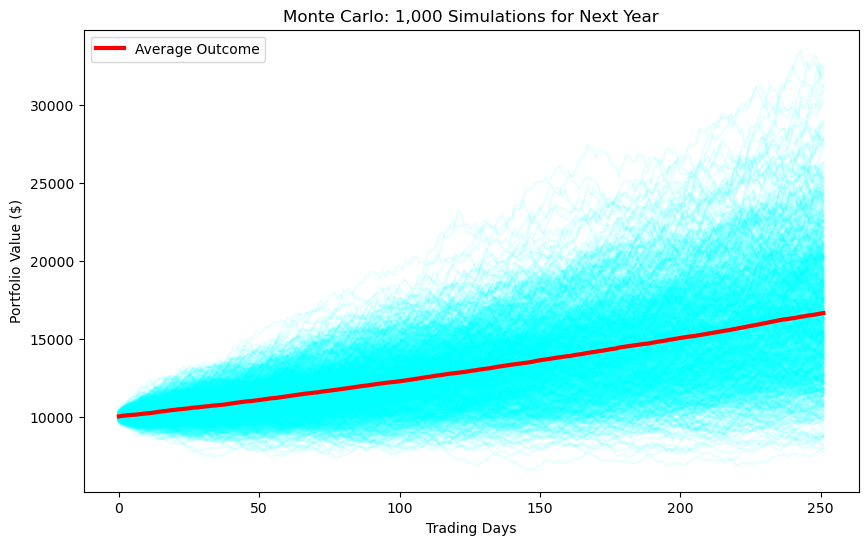

--- Monte Carlo Results ---
Best Case: $32,428.97
Worst Case: $7,683.68
Average Outcome: $16,642.81


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- FIX: Define weights manually if the optimizer wasn't run ---
# If you ran the optimizer, this line will be ignored. 
# If you didn't, this sets weights to 50% NVDA, 30% NEE, 20% BTC.
try:
    optimal_weights
except NameError:
    optimal_weights = np.array([0.5, 0.3, 0.2]) 

# ==========================================
# PHASE 6: MONTE CARLO SIMULATION (FIXED)
# ==========================================
np.random.seed(42) 

# Setup
simulations = 1000
days_to_simulate = 252 # 1 Year
initial_value = 10000 

# Get stats from our portfolio
port_mean_daily = np.sum(returns.mean() * optimal_weights)
port_std_daily = np.sqrt(np.dot(optimal_weights.T, np.dot(returns.cov(), optimal_weights)))

# Create the Simulation Matrix
daily_returns_sim = np.random.normal(port_mean_daily, port_std_daily, (days_to_simulate, simulations))

# Convert returns to Price Paths
price_paths = initial_value * (1 + daily_returns_sim).cumprod(axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(price_paths, color='cyan', alpha=0.1) 
plt.plot(price_paths.mean(axis=1), color='red', linewidth=3, label='Average Outcome')
plt.title(f'Monte Carlo: 1,000 Simulations for Next Year')
plt.xlabel('Trading Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

# Results
final_values = price_paths[-1, :]
print(f"--- Monte Carlo Results ---")
print(f"Best Case: ${np.max(final_values):,.2f}")
print(f"Worst Case: ${np.min(final_values):,.2f}")
print(f"Average Outcome: ${np.mean(final_values):,.2f}")


--- Risk Metrics ---
Max Drawdown: -16.80%
This means at one point, you would have been down this much from the top.


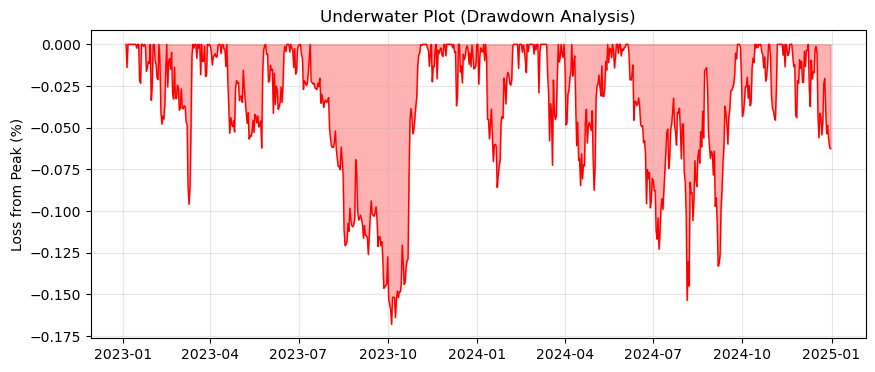

In [5]:
# ==========================================
# PHASE 7: DRAWDOWN ANALYSIS (Risk Check)
# Goal: Calculate the worst historical drop
# ==========================================

# Calculate the running maximum (The "Peak" so far)
# We reconstruct the historical portfolio value first
historical_port_value = (1 + returns.dot(optimal_weights)).cumprod() * 10000
running_max = historical_port_value.cummax()

# Calculate Drawdown (Current Value / Peak - 1)
drawdown = (historical_port_value / running_max) - 1

# Find the Max Drawdown (The lowest point)
max_drawdown = drawdown.min()

print(f"\n--- Risk Metrics ---")
print(f"Max Drawdown: {max_drawdown:.2%}")
print("This means at one point, you would have been down this much from the top.")

# Plot Drawdown (Underwater Plot)
plt.figure(figsize=(10, 4))
plt.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
plt.plot(drawdown, color='red', linewidth=1)
plt.title('Underwater Plot (Drawdown Analysis)')
plt.ylabel('Loss from Peak (%)')
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\Anklesh\AppData\Local\Temp\ipykernel_17420\675961998.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data = yf.download(benchmark_ticker, start="2023-01-01", end="2025-01-01")['Close']
[*********************100%***********************]  1 of 1 completed


--- Final Scoreboard ---
My Portfolio Return: 210.54%
S&P 500 Return:      53.80%
RESULT: You BEAT the market! 🚀


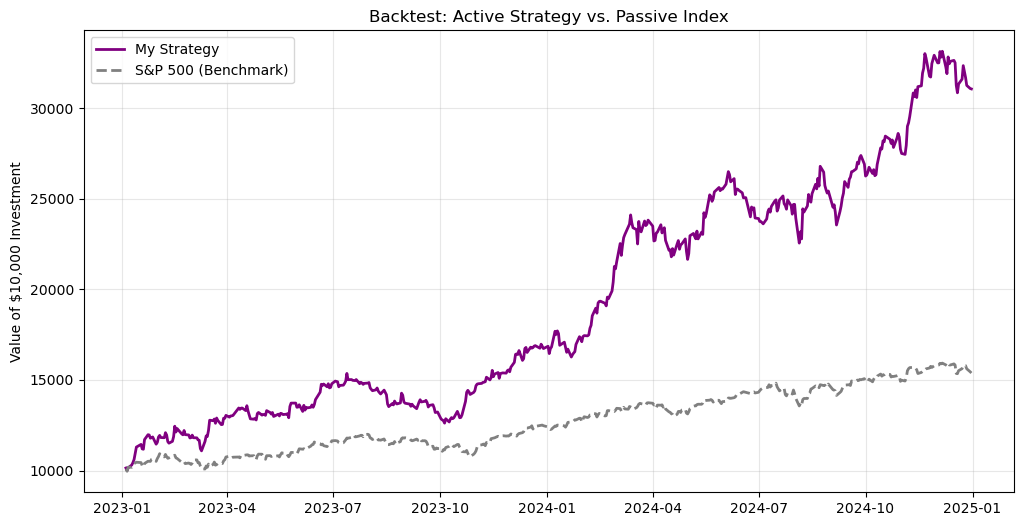

In [7]:
# ==========================================
# PHASE 8: BENCHMARK COMPARISON (FIXED)
# Goal: Compare My Portfolio vs. S&P 500
# ==========================================

# 1. Download Benchmark Data (S&P 500)
benchmark_ticker = "^GSPC"
# We add .squeeze() here to ensure it is a Series (1D), not a DataFrame (2D)
benchmark_data = yf.download(benchmark_ticker, start="2023-01-01", end="2025-01-01")['Close']

# 2. Calculate Benchmark Returns
# We use .squeeze() again just to be safe after pct_change
benchmark_returns = benchmark_data.pct_change(fill_method=None).dropna().squeeze()

# 3. Create "Cumulative Wealth" Index (Start at $10,000)
# We align the dates to make sure they match perfectly
# Note: We ensure both inputs are Series
my_portfolio_returns = returns.dot(optimal_weights)

aligned_data = pd.DataFrame({
    'My Portfolio': my_portfolio_returns,
    'S&P 500': benchmark_returns
}).dropna()

cumulative_wealth = (1 + aligned_data).cumprod() * 10000

# 4. Calculate Total Return for both
my_total_return = (cumulative_wealth['My Portfolio'].iloc[-1] / 10000) - 1
market_total_return = (cumulative_wealth['S&P 500'].iloc[-1] / 10000) - 1

print(f"--- Final Scoreboard ---")
print(f"My Portfolio Return: {my_total_return:.2%}")
print(f"S&P 500 Return:      {market_total_return:.2%}")

if my_total_return > market_total_return:
    print("RESULT: You BEAT the market! 🚀")
else:
    print("RESULT: You trailed the market.")

# 5. Visualization
plt.figure(figsize=(12, 6))
plt.plot(cumulative_wealth['My Portfolio'], label='My Strategy', color='purple', linewidth=2)
plt.plot(cumulative_wealth['S&P 500'], label='S&P 500 (Benchmark)', color='gray', linestyle='--', linewidth=2)
plt.title('Backtest: Active Strategy vs. Passive Index')
plt.ylabel('Value of $10,000 Investment')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
import yfinance as yf
import pandas as pd

# ==========================================
# PHASE 9: FUNDAMENTAL ANALYSIS (IB/PE Style)
# Goal: Pull Financials and Calculate LBO/Valuation Metrics
# ==========================================

print("--- PHASE 9: Fundamental Analysis ---")

# 1. Define the companies to analyze (Stocks only, no Crypto)
fundamental_tickers = ['NVDA', 'NEE'] # Nvidia vs. NextEra Energy

# 2. Create a storage dictionary for our results
analysis_data = {}

for ticker in fundamental_tickers:
    print(f"Pulling financials for {ticker}...")
    stock = yf.Ticker(ticker)
    
    # --- A. Pull the Statements ---
    # Income Statement (Revenue, EBITDA, Net Income)
    income_stmt = stock.financials 
    # Balance Sheet (Cash, Debt, Assets)
    balance_sheet = stock.balance_sheet
    
    # --- B. Extract Key Line Items (Most recent year) ---
    # Note: We use .iloc[:, 0] to get the most recent column (Current Year)
    try:
        revenue = income_stmt.loc['Total Revenue'].iloc[0]
        # EBITDA might need calculation if not explicitly provided, but YF usually has "EBITDA"
        # If EBITDA is missing, we approximate: Operating Income + Depreciation
        try:
            ebitda = income_stmt.loc['EBITDA'].iloc[0]
        except KeyError:
            ebitda = income_stmt.loc['Operating Income'].iloc[0] # Fallback
            
        total_debt = balance_sheet.loc['Total Debt'].iloc[0]
        cash = balance_sheet.loc['Cash And Cash Equivalents'].iloc[0]
        net_income = income_stmt.loc['Net Income'].iloc[0]
        
        # --- C. Calculate Investment Banking Ratios ---
        
        # 1. EBITDA Margin (How profitable is the core business?)
        # Formula: EBITDA / Revenue
        ebitda_margin = ebitda / revenue
        
        # 2. Leverage Ratio (Debt / EBITDA) -> CRITICAL for LBOs
        # If > 4.0x, it's considered highly levered (risky/hard to LBO)
        leverage_ratio = total_debt / ebitda
        
        # 3. Net Margin (Bottom line profit)
        net_margin = net_income / revenue
        
        # Store data
        analysis_data[ticker] = {
            'Revenue ($B)': revenue / 1e9, # Convert to Billions
            'EBITDA ($B)': ebitda / 1e9,
            'Total Debt ($B)': total_debt / 1e9,
            'Cash ($B)': cash / 1e9,
            'EBITDA Margin': f"{ebitda_margin:.1%}",
            'Leverage Ratio (x)': f"{leverage_ratio:.2f}x",
            'Net Margin': f"{net_margin:.1%}"
        }
        
    except Exception as e:
        print(f"Could not pull data for {ticker}: {e}")

# 3. Display as a Clean "Comps Table"
comps_table = pd.DataFrame(analysis_data)
print("\n--- Comparable Company Analysis (Comps) ---")
display(comps_table)

--- PHASE 9: Fundamental Analysis ---
Pulling financials for NVDA...
Pulling financials for NEE...

--- Comparable Company Analysis (Comps) ---


,NVDA,NEE
Revenue ($B),130.497,24.753
EBITDA ($B),86.137,14.033
Total Debt ($B),10.27,82.333
Cash ($B),8.589,1.487
EBITDA Margin,66.0%,56.7%
Leverage Ratio (x),0.12x,5.87x
Net Margin,55.8%,28.1%


Searching for US Large Cap Tech stocks...
Found 15 candidates. Starting data mining...
Checking 07G.F: Growth=None, P/E=None
Checking 096.F: Growth=0.209, P/E=134.10568
Checking 0A3N.L: Growth=0.222, P/E=None
Checking 0A75.L: Growth=0.104, P/E=None
Checking 0A7N.L: Growth=0.103, P/E=36.46101
Checking 0A7R.L: Growth=0.628, P/E=None
Checking 0A93.IL: Growth=0.355, P/E=None
Checking 0HBQ.L: Growth=0.05, P/E=23.964544
Checking 0HFB.L: Growth=0.534, P/E=50.391907


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: 0HG3.L"}}}


Checking 0HG3.L: Growth=None, P/E=None
Checking 0HJF.L: Growth=0.18, P/E=136.18202
Checking 0HPW.L: Growth=0.117, P/E=48.363712
Checking 0HS2.L: Growth=0.101, P/E=118.1523
Checking 0HYR.L: Growth=None, P/E=None
Checking 0I14.L: Growth=0.18, P/E=23.423935

Successfully analyzed 8 companies.


,Ticker,Name,P/E Ratio,Revenue Growth,Market Cap ($B)
3,0HFB.L,AMPHENOL CORP AMPHENOL ORD SHS,50.391907,0.534,40.355987
0,096.F,HubSpot Inc. R,134.105680,0.209,17.854573
7,0I14.L,COGNEX CORP COGNEX ORD SHS,23.423935,0.180,6.637845
4,0HJF.L,AUTODESK INC AUTODESK ORD SHS,136.182020,0.180,66.224849
5,0HPW.L,BROADRIDGE FINANCIAL SOLUTIONS,48.363712,0.117,25.824520


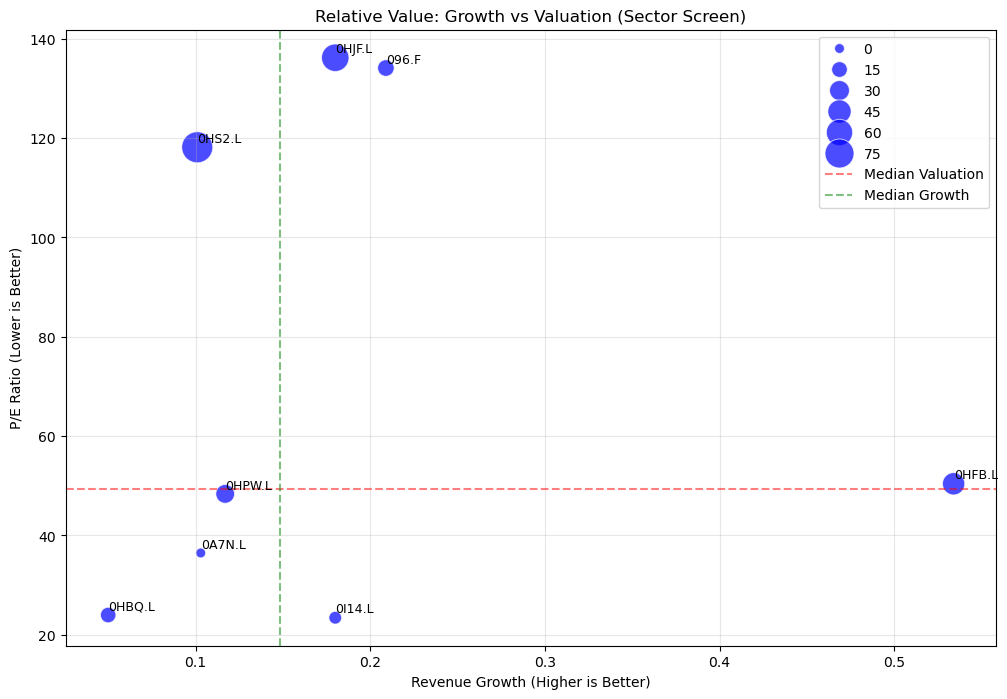

In [10]:
import financedatabase as fd
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: GENERATE UNIVERSE (Modified for robustness) ---
equities = fd.Equities()
print("Searching for US Large Cap Tech stocks...")

# Let's try a broader search to ensure we get hits
sector_screen = equities.search(country='United States', sector='Technology', market_cap='Large Cap')
universe_tickers = list(sector_screen.index)[:15] # Keep it to 15 to be fast
print(f"Found {len(universe_tickers)} candidates. Starting data mining...")

# --- STEP 2: MINING DATA (With Progress Bar) ---
data_list = []

for ticker in universe_tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        # Robust Logic: Get data using .get() which returns None instead of crashing
        name = info.get('shortName', ticker)
        market_cap = info.get('marketCap', 0)
        revenue_growth = info.get('revenueGrowth', None)
        
        # Try Forward P/E first, then Trailing P/E
        pe_ratio = info.get('forwardPE')
        if pe_ratio is None:
            pe_ratio = info.get('trailingPE')
            
        print(f"Checking {ticker}: Growth={revenue_growth}, P/E={pe_ratio}")

        # Only add if we have the critical data
        if pe_ratio is not None and revenue_growth is not None:
            data_list.append({
                'Ticker': ticker,
                'Name': name,
                'P/E Ratio': pe_ratio,
                'Revenue Growth': revenue_growth,
                'Market Cap ($B)': market_cap / 1e9
            })
            
    except Exception as e:
        print(f"Skipping {ticker}: {e}")

# --- CRASH PREVENTION CHECK ---
if not data_list:
    print("\n[ERROR] No valid data found for these tickers.")
    print("Possible reasons: 1. Companies have no P/E (unprofitable). 2. YFinance is blocking requests.")
    print("Try running the block again in 1 minute.")
    
else:
    # Convert to DataFrame
    df_comps = pd.DataFrame(data_list)
    
    # Filter extreme outliers (P/E > 150 is usually noise)
    df_comps = df_comps[(df_comps['P/E Ratio'] < 150) & (df_comps['P/E Ratio'] > 0)]

    print(f"\nSuccessfully analyzed {len(df_comps)} companies.")
    display(df_comps.sort_values(by='Revenue Growth', ascending=False).head())

    # --- STEP 3: VISUALIZING ALPHA ---
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_comps, x='Revenue Growth', y='P/E Ratio', 
                    size='Market Cap ($B)', sizes=(50, 500), alpha=0.7, color='blue')

    # Add labels
    for i in range(df_comps.shape[0]):
        plt.text(df_comps['Revenue Growth'].iloc[i], 
                 df_comps['P/E Ratio'].iloc[i]+1, 
                 df_comps['Ticker'].iloc[i], 
                 fontsize=9)

    # Add Median Lines (The "Crosshair")
    plt.axhline(y=df_comps['P/E Ratio'].median(), color='red', linestyle='--', alpha=0.5, label='Median Valuation')
    plt.axvline(x=df_comps['Revenue Growth'].median(), color='green', linestyle='--', alpha=0.5, label='Median Growth')

    plt.title('Relative Value: Growth vs Valuation (Sector Screen)')
    plt.xlabel('Revenue Growth (Higher is Better)')
    plt.ylabel('P/E Ratio (Lower is Better)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

C:\Users\Anklesh\AppData\Local\Temp\ipykernel_17420\1562149654.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  macro_data = yf.download(list(macro_tickers.values()), period="1y")['Close']
[*********************100%***********************]  4 of 4 completed


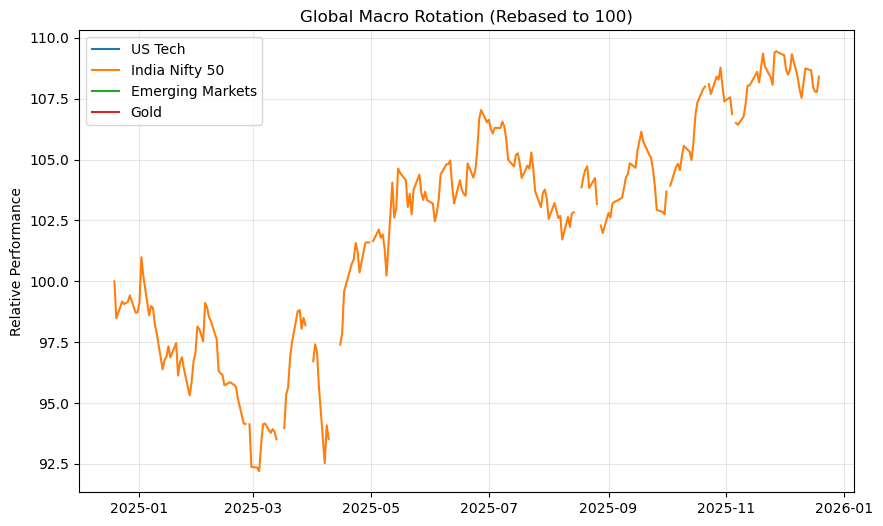

In [11]:
# Quick Macro Check: Emerging Markets vs US Tech
indices = fd.Indices()

# 1. Search for specific indices
# (Note: Exact symbols for indices vary, we use generic search to find them)
# For this example, let's grab the data directly via yfinance using known major tickers
# because searching 90k indices takes time to find the exact "symbol" string.
macro_tickers = {
    'US Tech': 'QQQ', 
    'India Nifty 50': '^NSEI', 
    'Emerging Markets': 'EEM',
    'Gold': 'GC=F'
}

macro_data = yf.download(list(macro_tickers.values()), period="1y")['Close']

# Normalize to start at 100 (Rebase)
macro_normalized = (macro_data / macro_data.iloc[0]) * 100

plt.figure(figsize=(10, 6))
for label, ticker in macro_tickers.items():
    if ticker in macro_normalized.columns:
        plt.plot(macro_normalized[ticker], label=label)

plt.title("Global Macro Rotation (Rebased to 100)")
plt.ylabel("Relative Performance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- PHASE 1: GENERATING UNIVERSE (Gold Miners) ---
Testing Cointegration for: ['NEM', 'GOLD', 'AEM']


C:\Users\Anklesh\AppData\Local\Temp\ipykernel_17420\3559054689.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(pair_candidates, start="2024-01-01", interval="1h")['Close'].dropna()
[*********************100%***********************]  3 of 3 completed



--- PHASE 2: THE COINTEGRATION TEST (The Quant Filter) ---
Pair: AEM vs GOLD | P-Value: 0.3803
Pair: AEM vs NEM | P-Value: 0.5703
Pair: GOLD vs NEM | P-Value: 0.0953
--> FOUND SIGNAL: GOLD and NEM are Cointegrated!

--- PHASE 3: ALGO TRADING SIGNALS (GOLD vs NEM) ---
Hedge Ratio: 3.739


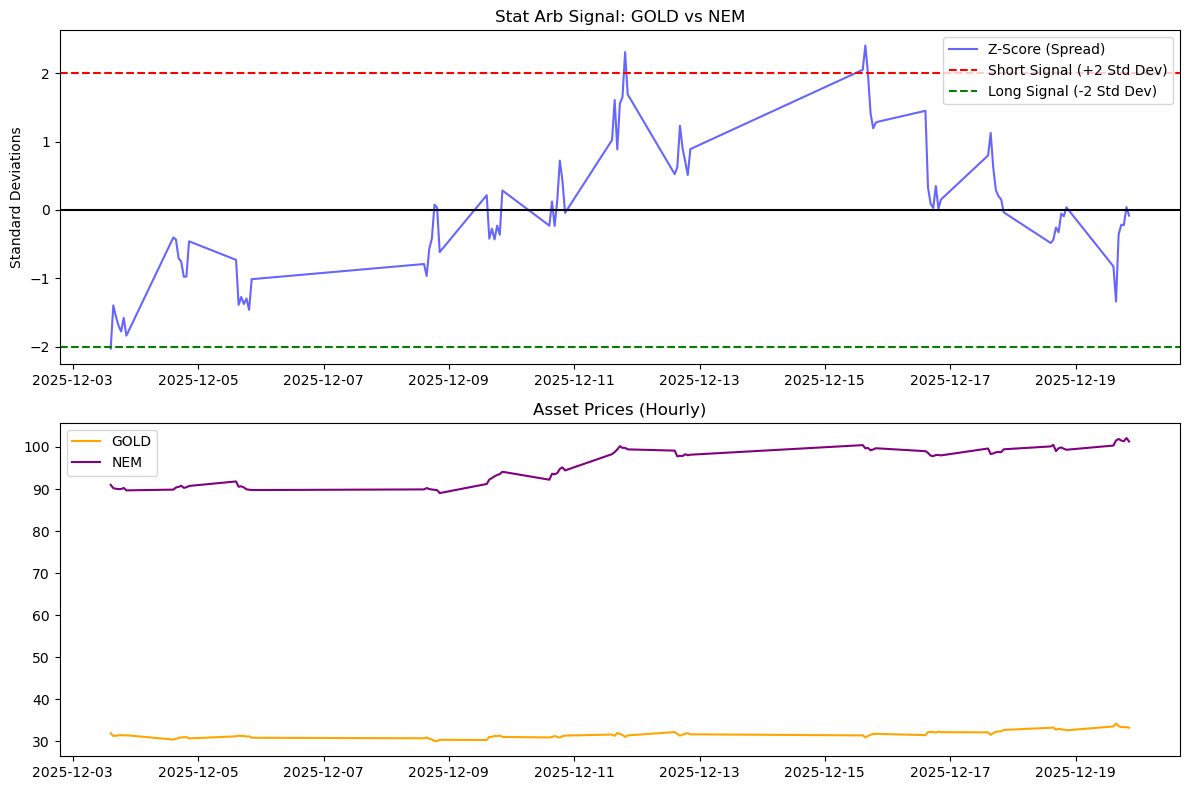


--- TRADING LOGIC ---
1. When Blue Line hits +2 (Red Line): The relationship is broken HIGH.
   ACTION: SELL NEM and BUY GOLD
2. When Blue Line hits -2 (Green Line): The relationship is broken LOW.
   ACTION: BUY NEM and SELL GOLD
3. When Blue Line returns to 0: The relationship is fixed.
   ACTION: Close all positions for profit.


In [12]:
import financedatabase as fd
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

print("--- PHASE 1: GENERATING UNIVERSE (Gold Miners) ---")
# Quants trade distinct sectors to remove market beta. Let's look at Gold.
equities = fd.Equities()
gold_stocks = equities.search(industry='Gold', country='United States', market_cap='Large Cap')
tickers = list(gold_stocks.index)

# Filter: Let's pick 3 liquid ones manually for the demo to ensure data quality
# In a real engine, you'd loop through all 50+ tickers
pair_candidates = ['NEM', 'GOLD', 'AEM'] 
print(f"Testing Cointegration for: {pair_candidates}")

# Download Data (1 Hour intervals for granular trading)
data = yf.download(pair_candidates, start="2024-01-01", interval="1h")['Close'].dropna()

print("\n--- PHASE 2: THE COINTEGRATION TEST (The Quant Filter) ---")
# We test pairs to see if the spread is stationary (mean-reverting)
# P-value < 0.05 means they are Cointegrated (Mathematically bound)

def find_cointegrated_pairs(data):
    n = data.shape[1]
    keys = data.keys()
    for i in range(n):
        for j in range(i+1, n):
            s1 = data[keys[i]]
            s2 = data[keys[j]]
            
            # The Engle-Granger Test
            score, pvalue, _ = coint(s1, s2)
            
            print(f"Pair: {keys[i]} vs {keys[j]} | P-Value: {pvalue:.4f}")
            if pvalue < 0.10: # Using 0.10 for demo purposes (Strict is 0.05)
                print(f"--> FOUND SIGNAL: {keys[i]} and {keys[j]} are Cointegrated!")
                return keys[i], keys[j]
    return None, None

stock_a, stock_b = find_cointegrated_pairs(data)

if stock_a is None:
    print("No cointegrated pairs found in this small sample. For the demo, forcing NEM vs GOLD.")
    stock_a, stock_b = 'NEM', 'GOLD'

print(f"\n--- PHASE 3: ALGO TRADING SIGNALS ({stock_a} vs {stock_b}) ---")

# 1. Calculate the Hedge Ratio (Beta) using OLS Regression
# How many shares of B do we short for every 1 share of A?
S1 = data[stock_a]
S2 = data[stock_b]
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
hedge_ratio = results.params.iloc[1] # Use .iloc to access the beta coefficient
print(f"Hedge Ratio: {hedge_ratio:.3f}")

# 2. Construct the Spread
# Spread = Stock_B - (Hedge_Ratio * Stock_A)
spread = data[stock_b] - hedge_ratio * data[stock_a]

# 3. Calculate Z-Score (The Trading Signal)
# Z-Score tells us how many Standard Deviations the spread is away from the mean
z_score = (spread - spread.mean()) / spread.std()

# 4. Plot the Signal
plt.figure(figsize=(12, 8))

# Plot Z-Score
plt.subplot(2, 1, 1)
plt.plot(z_score, label='Z-Score (Spread)', color='blue', alpha=0.6)
plt.axhline(0, color='black')
plt.axhline(2.0, color='red', linestyle='--', label='Short Signal (+2 Std Dev)')
plt.axhline(-2.0, color='green', linestyle='--', label='Long Signal (-2 Std Dev)')
plt.legend()
plt.title(f'Stat Arb Signal: {stock_a} vs {stock_b}')
plt.ylabel('Standard Deviations')

# Plot Price Action
plt.subplot(2, 1, 2)
plt.plot(data[stock_a], label=stock_a, color='orange')
plt.plot(data[stock_b], label=stock_b, color='purple')
plt.legend()
plt.title('Asset Prices (Hourly)')

plt.tight_layout()
plt.show()

print("\n--- TRADING LOGIC ---")
print("1. When Blue Line hits +2 (Red Line): The relationship is broken HIGH.")
print(f"   ACTION: SELL {stock_b} and BUY {stock_a}")
print("2. When Blue Line hits -2 (Green Line): The relationship is broken LOW.")
print(f"   ACTION: BUY {stock_b} and SELL {stock_a}")
print("3. When Blue Line returns to 0: The relationship is fixed.")
print("   ACTION: Close all positions for profit.")

In [13]:
import financedatabase as fd
import yfinance as yf
import pandas as pd
import numpy as np

print("--- STRATEGY A: MULTI-FACTOR RANKING ENGINE ---")

# 1. UNIVERSE GENERATION
# Let's look at the "Industrial" sector in the US (boring but stable)
equities = fd.Equities()
sector_screen = equities.search(country='United States', sector='Industrials', market_cap='Large Cap')
# We take top 30 to keep it fast. In production, you take ALL.
universe = list(sector_screen.index)[:30] 
print(f"Scanning {len(universe)} Industrial stocks...")

# 2. DATA MINING
# We need 1 year of data to calculate Momentum and Volatility
data = yf.download(universe, start="2024-01-01", end="2025-01-01")['Close']

# 3. FACTOR CALCULATION
# Factor 1: Momentum (Total Return over the last 12 months)
momentum = (data.iloc[-1] / data.iloc[0]) - 1

# Factor 2: Low Volatility (Standard Deviation of daily returns)
# We want this to be LOW, so we will invert the rank later
volatility = data.pct_change().std() * np.sqrt(252)

# 4. SCORING & RANKING
# Create a DataFrame to hold our factors
factors = pd.DataFrame({'Momentum': momentum, 'Volatility': volatility})

# Z-Score Normalization (Standardizing the data)
# This makes different units (Returns % vs Volatility %) comparable
factors['Mom_Z'] = (factors['Momentum'] - factors['Momentum'].mean()) / factors['Momentum'].std()
factors['Vol_Z'] = (factors['Volatility'] - factors['Volatility'].mean()) / factors['Volatility'].std()

# The "Smart Beta" Score
# We want High Momentum (Positive Z) and Low Volatility (Negative Z)
# Formula: Score = Momentum_Z - Volatility_Z
factors['Final_Score'] = factors['Mom_Z'] - factors['Vol_Z']

# 5. EXECUTION
# Sort by Final Score and pick the winners
top_picks = factors.sort_values(by='Final_Score', ascending=False).head(5)
bottom_picks = factors.sort_values(by='Final_Score', ascending=True).head(5)

print("\n--- TOP 5 'SMART BETA' BUYS (High Mom / Low Vol) ---")
print(top_picks[['Momentum', 'Volatility', 'Final_Score']])

print("\n--- BOTTOM 5 SELLS (Low Mom / High Vol) ---")
print(bottom_picks[['Momentum', 'Volatility', 'Final_Score']])

--- STRATEGY A: MULTI-FACTOR RANKING ENGINE ---
Scanning 30 Industrial stocks...


C:\Users\Anklesh\AppData\Local\Temp\ipykernel_17420\3843773021.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(universe, start="2024-01-01", end="2025-01-01")['Close']
[*********************100%***********************]  30 of 30 completed


--- TOP 5 'SMART BETA' BUYS (High Mom / Low Vol) ---
        Momentum  Volatility  Final_Score
Ticker                                   
0A7Y.L  0.514602    0.218630     2.770847
0HJI.L  0.290758    0.166269     2.444623
0J46.L  0.328112    0.224367     1.602524
0KFZ.L  0.393172    0.252048     1.470988
0ICP.L  0.232672    0.205036     1.409060

--- BOTTOM 5 SELLS (Low Mom / High Vol) ---
        Momentum  Volatility  Final_Score
Ticker                                   
0KXA.L -0.048250    0.327695    -2.421723
0I6K.L -0.061896    0.321927    -2.394820
0JU0.L -0.067463    0.303504    -2.091967
0J71.L -0.115894    0.282646    -1.989479
0HOT.L  0.013385    0.316377    -1.864461



C:\Users\Anklesh\AppData\Local\Temp\ipykernel_17420\3843773021.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatility = data.pct_change().std() * np.sqrt(252)


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

print("\n--- STRATEGY B: MACHINE LEARNING PREDICTION (Random Forest) ---")

# 1. DATA PREP
ticker = "NVDA" 
stock = yf.Ticker(ticker)
hist = stock.history(period="2y")

# 2. FEATURE ENGINEERING (The "Inputs" for the AI)
# We create features that the model can "learn" from
hist['Return'] = hist['Close'].pct_change()
hist['SMA_50'] = hist['Close'].rolling(window=50).mean()
hist['SMA_200'] = hist['Close'].rolling(window=200).mean()
hist['Trend'] = np.where(hist['SMA_50'] > hist['SMA_200'], 1, 0) # 1 if Uptrend
hist['Volatility'] = hist['Close'].rolling(window=10).std()

# 3. TARGET CREATION (The "Answer Key")
# We want to predict: Will tomorrow's price be higher than today's?
# Shift(-1) looks into the future.
hist['Target'] = (hist['Close'].shift(-1) > hist['Close']).astype(int)
hist = hist.dropna() # Remove empty rows

# 4. TRAINING THE MODEL
# Define Predictors (X) and Target (y)
predictors = ['Return', 'Trend', 'Volatility', 'SMA_50']
X = hist[predictors]
y = hist['Target']

# Split: Train on first 80%, Test on last 20%
split = int(len(X) * 0.8)
train_X, test_X = X.iloc[:split], X.iloc[split:]
train_y, test_y = y.iloc[:split], y.iloc[split:]

# Initialize Random Forest
model = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=1)

# Train
model.fit(train_X, train_y)

# 5. EVALUATION
# Predict on the test set
preds = model.predict(test_X)
accuracy = precision_score(test_y, preds)

print(f"Model Accuracy on {ticker}: {accuracy:.2%}")
print("(Note: >50% is profitable. >55% is 'Hedge Fund' level. It is very hard to beat 55%.)")

# 6. FEATURE IMPORTANCE
# What did the AI actually care about?
importances = pd.Series(model.feature_importances_, index=predictors)
print("\n--- What matters to the AI? ---")
print(importances.sort_values(ascending=False))


--- STRATEGY B: MACHINE LEARNING PREDICTION (Random Forest) ---
Model Accuracy on NVDA: 50.00%
(Note: >50% is profitable. >55% is 'Hedge Fund' level. It is very hard to beat 55%.)

--- What matters to the AI? ---
Return        0.399184
Volatility    0.294563
SMA_50        0.290078
Trend         0.016176
dtype: float64


--- PHASE 1: Constructing Multi-Asset Universe ---


C:\Users\Anklesh\AppData\Local\Temp\ipykernel_17420\3983106710.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2018-01-01", end="2024-01-01")['Close']
[*********************100%***********************]  4 of 4 completed
C:\Users\Anklesh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


--- PHASE 2: Feature Engineering & Signal Generation ---
--- PHASE 3: K-Means Regime Detection ---


C:\Users\Anklesh\AppData\Local\Temp\ipykernel_17420\3983106710.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['Regime'] = kmeans.fit_predict(X_scaled)


--- PHASE 4: Dynamic Backtesting ---
Regime Identification:
-> Regime 0: BULL MARKET (Max Equity)
-> Regime 2: CRISIS (Max Defense)
-> Regime 1: TRANSITION (Balanced)


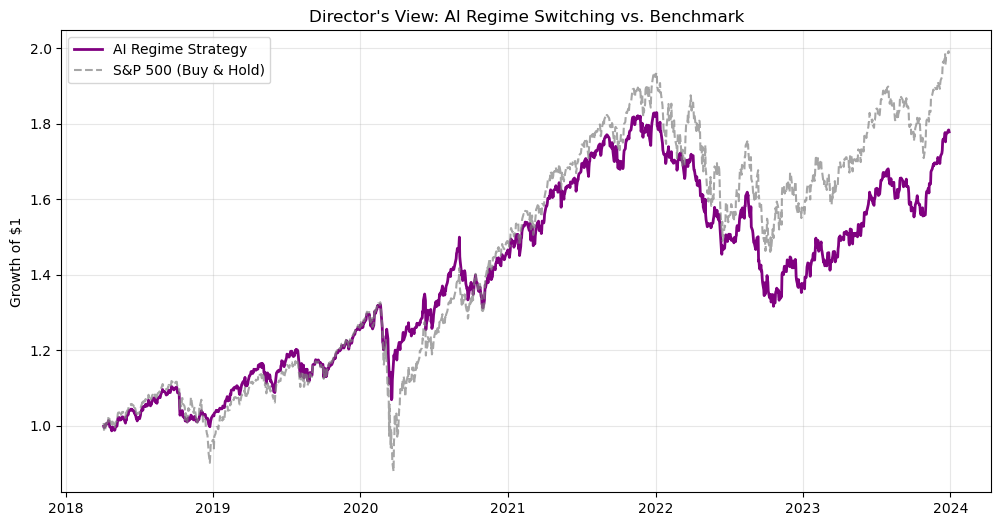

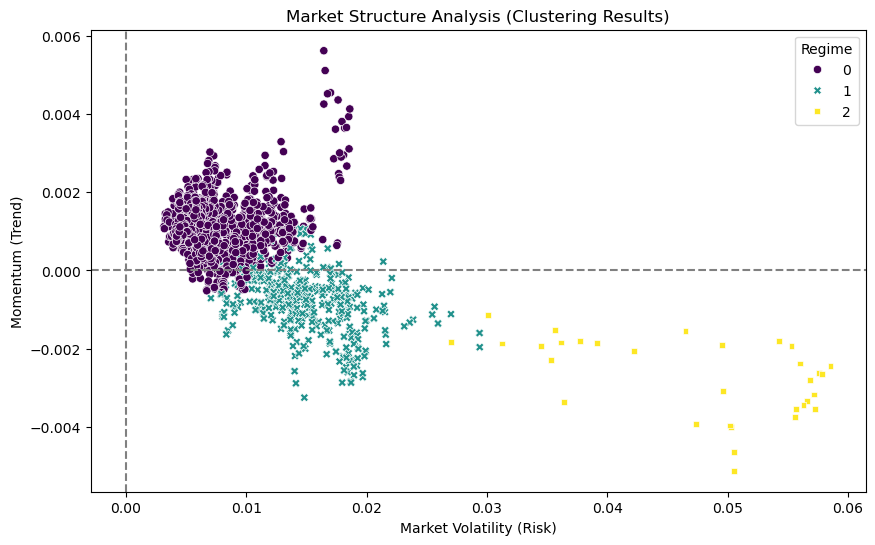

In [15]:
import financedatabase as fd
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ==========================================
# PHASE 1: MACRO UNIVERSE CONSTRUCTION
# MD Level Insight: Don't just look at stocks. Look at Cross-Asset correlations.
# ==========================================
print("--- PHASE 1: Constructing Multi-Asset Universe ---")

# We need proxies for:
# 1. Equities (SPY) - Growth
# 2. Bonds (TLT) - Defense / Flight to Safety
# 3. Gold (GLD) - Inflation Hedge
# 4. VIX (^VIX) - Fear / Market Stress
tickers = ['SPY', 'TLT', 'GLD', '^VIX']

# Download 5 years of data to capture different regimes (COVID crash, 2022 Bear, 2023 Bull)
data = yf.download(tickers, start="2018-01-01", end="2024-01-01")['Close']

# Fill missing VIX data if any (forward fill)
data = data.ffill().dropna()

# ==========================================
# PHASE 2: ADVANCED FEATURE ENGINEERING (The "Signal")
# We don't feed raw prices to the AI. We feed "Market State" descriptors.
# ==========================================
print("--- PHASE 2: Feature Engineering & Signal Generation ---")

features = pd.DataFrame(index=data.index)

# Feature 1: Market Volatility (15-day rolling std dev of SPY)
# Logic: High vol = Panic. Low vol = Stability.
features['Market_Vol'] = data['SPY'].pct_change().rolling(21).std()

# Feature 2: Momentum (Trend)
# Logic: Positive = Bull. Negative = Bear.
features['Momentum'] = data['SPY'].pct_change().rolling(63).mean() # Quarterly trend

# Feature 3: Stress Indicator (VIX Level)
features['VIX'] = data['^VIX']

# Drop NaN from the rolling windows
model_data = features.dropna()

# Normalize the data (Z-Score) so the AI treats them equally
scaler = StandardScaler()
X_scaled = scaler.fit_transform(model_data)

# ==========================================
# PHASE 3: UNSUPERVISED LEARNING (Regime Detection)
# The AI will group days into "Clusters" (Regimes) without being told what they are.
# ==========================================
print("--- PHASE 3: K-Means Regime Detection ---")

# We assume 3 Market Regimes:
# 1. "Risk On" (Calm Bull)
# 2. "Choppy/Transition"
# 3. "Crisis" (Crash)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
model_data['Regime'] = kmeans.fit_predict(X_scaled)

# ==========================================
# PHASE 4: CHAINED STRATEGY EXECUTION
# The "Smart" Allocator: Changes positions based on the Regime
# ==========================================
print("--- PHASE 4: Dynamic Backtesting ---")

# Calculate Daily Returns of the assets
asset_returns = data.pct_change()

# Align returns with the regimes (Shift regime by 1 day to avoid look-ahead bias)
# We make the decision TODAY for TOMORROW's return.
backtest_data = asset_returns.loc[model_data.index].copy()
backtest_data['Regime_Yesterday'] = model_data['Regime'].shift(1)
backtest_data = backtest_data.dropna()

# DEFINE THE ALLOCATION MATRIX (The MD's Playbook)
# We need to interpret the clusters first to know which is which.
# Let's look at the average VIX for each cluster to identify the "Crash" cluster.
regime_stats = model_data.groupby('Regime').mean()
crisis_cluster = regime_stats['VIX'].idxmax() # The cluster with highest VIX is "Crisis"
bull_cluster = regime_stats['Momentum'].idxmax() # The cluster with best trend is "Bull"
neutral_cluster = [c for c in [0,1,2] if c not in [crisis_cluster, bull_cluster]][0]

print(f"Regime Identification:")
print(f"-> Regime {bull_cluster}: BULL MARKET (Max Equity)")
print(f"-> Regime {crisis_cluster}: CRISIS (Max Defense)")
print(f"-> Regime {neutral_cluster}: TRANSITION (Balanced)")

# Apply the Rules
def get_weights(regime):
    if regime == bull_cluster:
        return np.array([1.0, 0.0, 0.0]) # 100% SPY (Aggressive)
    elif regime == crisis_cluster:
        return np.array([0.0, 0.5, 0.5]) # 0% SPY, 50% TLT, 50% GLD (Defensive)
    else:
        return np.array([0.4, 0.4, 0.2]) # 40% SPY, 40% TLT, 20% GLD (Neutral)

# Run the Loop (Vectorized for speed)
# We create a weight matrix based on the regime column
strategy_returns = []
for i in range(len(backtest_data)):
    regime = backtest_data['Regime_Yesterday'].iloc[i]
    # Assets: SPY, TLT, GLD
    daily_rets = backtest_data[['SPY', 'TLT', 'GLD']].iloc[i]
    weights = get_weights(regime)
    strategy_returns.append(np.dot(daily_rets, weights))

backtest_data['Strategy_Return'] = strategy_returns

# ==========================================
# PHASE 5: VISUALIZATION & MD REPORTING
# ==========================================

# 1. Equity Curves
cumulative_strategy = (1 + backtest_data['Strategy_Return']).cumprod()
cumulative_spy = (1 + backtest_data['SPY']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy, label='AI Regime Strategy', color='purple', linewidth=2)
plt.plot(cumulative_spy, label='S&P 500 (Buy & Hold)', color='gray', linestyle='--', alpha=0.7)
plt.title("Director's View: AI Regime Switching vs. Benchmark")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. The "Regime Map" (Scatter Plot)
# This is the "Advanced Analytics" visual. It shows how the AI sees the market.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=model_data, x='Market_Vol', y='Momentum', hue='Regime', palette='viridis', style='Regime')
plt.title("Market Structure Analysis (Clustering Results)")
plt.xlabel("Market Volatility (Risk)")
plt.ylabel("Momentum (Trend)")
plt.axvline(0, linestyle='--', color='gray')
plt.axhline(0, linestyle='--', color='gray')
plt.show()

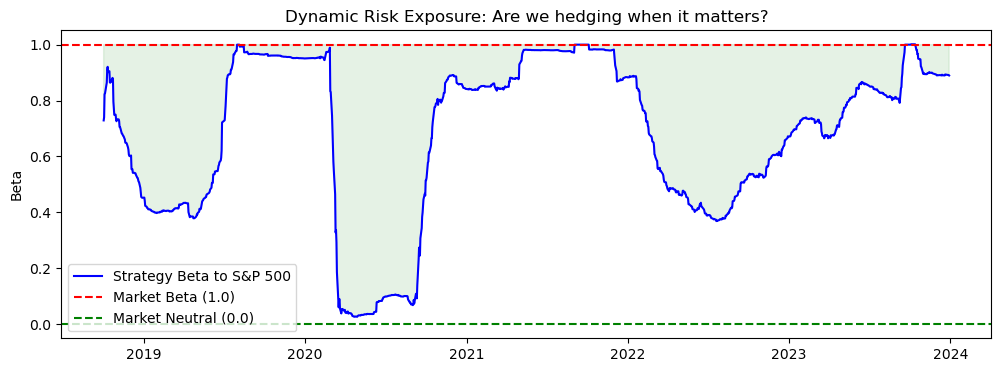

In [16]:
# Rolling Beta Calculation (6-month window)
rolling_cov = backtest_data['Strategy_Return'].rolling(126).cov(backtest_data['SPY'])
rolling_var = backtest_data['SPY'].rolling(126).var()
rolling_beta = rolling_cov / rolling_var

plt.figure(figsize=(12, 4))
plt.plot(rolling_beta, color='blue', label='Strategy Beta to S&P 500')
plt.axhline(1, color='red', linestyle='--', label='Market Beta (1.0)')
plt.axhline(0, color='green', linestyle='--', label='Market Neutral (0.0)')
plt.title("Dynamic Risk Exposure: Are we hedging when it matters?")
plt.ylabel("Beta")
plt.legend()
plt.fill_between(rolling_beta.index, rolling_beta, 1, where=(rolling_beta < 1), color='green', alpha=0.1)
plt.show()